In [1]:
from tensorflow.keras.models import load_model
from VisionUtils import *
from imgaug import augmenters as iaa
from Manager import *
import tensorflow.keras.backend as k
import tensorflow as tf

import matplotlib.pyplot as plt
import os 
import imgaug


In [2]:
m = load_model("Feature_Extractor_trainer/Models/FaceNet/facenet_keras.h5")
face_detector =MTCNN()

W0904 15:26:28.645373 12984 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0904 15:26:28.672293 12984 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\mtcnn\mtcnn.py:187: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0904 15:26:28.676844 12984 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\mtcnn\mtcnn.py:193: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0904 15:26:28.709685 12984 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\mtcnn\network.py:43: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0904 15:26:28.711417 12984 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\mtcnn\layer_factory.py:88: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 15:26:28.71

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
images = [img, img,img1, img1, img, img, img, img1, img1, img1]
seq = iaa.Sequential([
    iaa.Add(per_channel=True),
    sometimes(iaa.SigmoidContrast()), 
    #iaa.SaltAndPepper(p = 0.05),
    sometimes(iaa.GammaContrast(per_channel=True, gamma = 1.75)),
    sometimes(iaa.GammaContrast(per_channel = True, gamma = 0.75)),
    sometimes(iaa.Multiply(0.45)),
    sometimes(iaa.Multiply(0.75)),
    sometimes(iaa.HistogramEqualization())
], random_order = True)

images_aug = seq.augment_images(images)

print("Augmented:")
ia.imshow(np.hstack(images_aug))


In [3]:
### Important Dirrectories
IMG_RT_PATH = 'data/images/'
FEATURE_RT_PATH = "data/image_features/"
FEATURE_AUG_RT_PATH = "data/image_aug_features/"
IMG_AUG_RT_PATH = 'data/images_aug/'

### Get all images paths 
img_path_list = []
folder_list = os.listdir(IMG_RT_PATH)
for FOLDER in folder_list:
    image_list_names = os.listdir(IMG_RT_PATH + FOLDER)
    for NAME in image_list_names:
        img_path_list.append(FOLDER+'/'+NAME)
        
img_list = pd.DataFrame({"path": img_path_list})

In [4]:
iman = ImageManager(
    imgpaths = img_list,
    feature_extractor = m,
    face_detector =  face_detector, 
    IMG_RTPATH = IMG_RT_PATH,)

In [5]:
iman.balance_random_sample(50)
paths = iman.get_sample_image_paths()
iman.split(train_size = 0.8)
paths1 = list(iman.xtrainp["path1"].values)
paths2 = list(iman.xtrainp["path2"].values)
ytrain = iman.ytrainp

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
img = plt.imread("demo/database/pics/April.jpg")
img = cv2.resize(img, (600, 600))

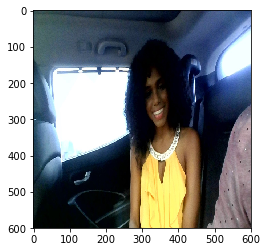

In [7]:
plt.imshow(img)

In [8]:
input_shape = m.input_shape[1:]

In [9]:
for layer in m.layers[:-6]:
    layer.trainable = False

In [10]:
def squared_differences(pair_of_tensors):
    x, y = pair_of_tensors
    return k.square(x - y)

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, add

inputs1 = Input(input_shape)
inputs2 = Input(input_shape)
x1 = m(inputs1)
x2 = m(inputs2)
x1 = Model(inputs = inputs1, outputs = x1)
x2 = Model(inputs = inputs2, outputs = x2)


x = Lambda(squared_differences)([x1.output, x2.output])
output = Dense(1, activation = 'sigmoid')(x)

In [12]:
model = Model(inputs =[x1.input,x2.input], outputs=output)
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01), 
    loss = 'binary_crossentropy', 
    metrics = ["accuracy"],
)


W0904 15:26:53.554678 12984 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:

for p1, p2 in zip(paths1, paths2):
    if (p1[:7] == p2[:7]):
        y.append(1)
    else: 
        y.append(0)

In [28]:
p1[:7]

'n001199'

In [29]:
p1

'n001199/0401_01.jpg'

training_images1 = []
training_images2 = []
i = 0
n = 0
batch = 500
total = len(paths1)//batch
y  = []
for path1, path2 in zip(paths1, paths2):
    if (os.path.isfile(IMG_RT_PATH + path1) and os.path.isfile(IMG_RT_PATH + path2)):
        img1 = plt.imread(IMG_RT_PATH + path1)
        img2 = plt.imread(IMG_RT_PATH + path2)
    bb1 = detect_faces(img1, face_detector)
    bb2 = detect_faces(img2, face_detector)
    ### If more than one faces are detected 
    ### ignore 
    if ((len(bb1)!=1) or (len(bb2)!=1)):
        continue
    if (path1[:7] == path2[:7]):
        y.append(1)
    else: 
        y.append(0)
    img1 = crop_face( normalize(img1), bb1[0])
    img1 = cv2.resize(img1,(input_shape[0],input_shape[1]))
    img2 = crop_face( normalize(img2), bb2[0])
    img2 = cv2.resize(img2,(input_shape[0],input_shape[1]))
    show_img(img1)
    show_img(img2)
    print(y[i])
    print(path1)
    print(path2)
    i = i +1
    if(i == 10): break

In [18]:
len(paths1)

15200

In [34]:
training_images1 = []
training_images2 = []
i = 0
n = 0
batch = 100
total = len(paths1)//batch
y = []
for path1, path2 in zip(paths1, paths2):
    if (os.path.isfile(IMG_RT_PATH + path1) and os.path.isfile(IMG_RT_PATH + path2)):
        img1 = plt.imread(IMG_RT_PATH + path1)
        img2 = plt.imread(IMG_RT_PATH + path2)
    bb1 = detect_faces(img1, face_detector)
    bb2 = detect_faces(img2, face_detector)
    ### If more than one faces are detected 
    ### ignore 
    if ((len(bb1)!=1) or (len(bb2)!=1)):
        continue
    if (path1[:7] == path2[:7]):
        y.append(1)
    else: 
        y.append(0)
    img1 = crop_face( normalize(img1), bb1[0])
    img1 = cv2.resize(img1,(input_shape[0],input_shape[1]))
    img2 = crop_face( normalize(img2), bb2[0])
    img2 = cv2.resize(img2,(input_shape[0],input_shape[1]))
    training_images1.append(img1)
    training_images2.append(img2)
    #show_img(img1)
    #show_img(img2)
    #print(iman.ytrainp[i])
    #print(path1)
    #print(path2)
    i = i + 1
    if(i==batch):
        ytr = np.array(y)
        xtr1 = np.array(training_images1)
        xtr2 = np.array(training_images2)
        print(n)
        model.fit((xtr1, xtr2), ytr)
        training_images1 = []
        training_images2 = []
        y = []
        i = 0
        n = n +1
        
        if (n == total ): break


0
100/100 [==============================] - 7s 67ms/sample - loss: 0.2987 - acc: 0.8900
1
100/100 [==============================] - 7s 66ms/sample - loss: 0.2392 - acc: 0.9200
2
100/100 [==============================] - 7s 67ms/sample - loss: 0.3586 - acc: 0.8800
3
100/100 [==============================] - 7s 67ms/sample - loss: 0.2825 - acc: 0.8800
4
100/100 [==============================] - 7s 68ms/sample - loss: 0.3019 - acc: 0.8800
5
100/100 [==============================] - 7s 69ms/sample - loss: 0.4258 - acc: 0.7900
6
100/100 [==============================] - 7s 67ms/sample - loss: 0.2754 - acc: 0.9100
7
100/100 [==============================] - 7s 73ms/sample - loss: 0.2731 - acc: 0.9000
8
100/100 [==============================] - 7s 72ms/sample - loss: 0.2590 - acc: 0.9000
9
100/100 [==============================] - 7s 73ms/sample - loss: 0.3834 - acc: 0.8500
10
100/100 [==============================] - 7s 67ms/sample - loss: 0.3267 - acc: 0.8600
11
100/100 [========

(500,)

In [ ]:
ytr

In [ ]:
np.array(iman.ytrainp[i])

In [ ]:
inputs2 

In [ ]:
#os.listdir("data/images/n000001")
bb_lst = detect_faces(img, face_detector)
bb = bb_lst[0]
insz = model.input_shape
img = crop_face(img, bb)
img = resize(img,(insz[1],insz[2]))
img = normalize(img).reshape((1, insz[1],insz[2], insz[3]))

In [ ]:
m.summary()

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [ ]:
image_generator = image_datagen.flow_from_directory(
    'data/images',
    class_mode=None,
    seed=seed)